In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read the CSV file into a DataFrame
df_gt = pd.read_csv('/home/ece/Desktop/Negative_Sampling/LightGCN-PyTorch/data/lastfm/all_data.csv', header=None)
df_gt = df_gt.rename(columns={1:'user_id', 2:'GT_item_id'})
df_gt = df_gt[['user_id', 'GT_item_id']]

In [3]:
# Path to the pickle file
train_1_1_path = '/home/ece/Desktop/Negative_Sampling/LightGCN-PyTorch/data/lastfm/train_with_negs_1_1.pkl'
test_path = '/home/ece/Desktop/Negative_Sampling/LightGCN-PyTorch/data/lastfm/test_dict.pkl'
train_1_100_path = '/home/ece/Desktop/Negative_Sampling/LightGCN-PyTorch/data/lastfm/train_with_negs_1_100.pkl'

with open(train_1_1_path, 'rb') as file:
    # Load the data from the pickle file
    train_1_1 = pickle.load(file)

with open(test_path, 'rb') as file:
    # Load the data from the pickle file
    test = pickle.load(file)

with open(train_1_100_path, 'rb') as file:
    # Load the data from the pickle file
    train_1_100 = pickle.load(file)

#### test data analysis

In [4]:
# Get the unique set of all item IDs
all_items = set(item for items in test.values() for item in items)

# Create a list of dictionaries
test_data = []
for user_id, pos_items in test.items():
    neg_items = list(all_items - set(pos_items))
    test_data.append({'user_id': user_id, 'pos_items': pos_items, 'neg_items': neg_items})

# Create a DataFrame
df_test = pd.DataFrame(test_data)

In [5]:
df_test

,user_id,pos_items,neg_items
0,1319,"[120, 1502, 4457, 4403, 127, 371, 633, 3379]","[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."
1,730,"[1171, 926, 104, 624, 623, 3154, 208, 2994, 28...","[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."
2,1781,"[444, 1187, 2156, 1519, 610, 2468, 3254, 3967,...","[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."
3,415,"[3445, 1745, 3359]","[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."
4,117,"[380, 1900, 1901]","[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."
...,...,...,...
1853,592,"[175, 1790]","[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."
1854,998,[4338],"[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."
1855,935,[274],"[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."
1856,1117,[560],"[1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, ..."


In [6]:
# Get frequency dictionary for pos_items column
pos_items_freq = df_test['pos_items'].apply(pd.Series).stack().value_counts().to_dict()
pos_items_freq = {int(k): v for k, v in pos_items_freq.items()}

In [7]:
# Get frequency dictionary for neg_items column
neg_items_freq = df_test['neg_items'].apply(pd.Series).stack().value_counts().to_dict()
neg_items_freq = {int(k): v for k, v in neg_items_freq.items()}

In [8]:
# Create an empty list to store the rows of the numpy array
rows = []

# Iterate over the DataFrame with tqdm to display a progress bar
for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    user_id = row['user_id']
    for pos_item_id in row['pos_items']:
        pos_item_freq = pos_items_freq.get(pos_item_id, 0)
        for neg_item_id in row['neg_items']:
            neg_item_freq = neg_items_freq.get(neg_item_id, 0)
            rows.append([user_id, pos_item_id, pos_item_freq, neg_item_id, neg_item_freq])

# Convert the list of rows into a numpy array
np_array_train = np.array(rows)

  0%|          | 0/1858 [00:00<?, ?it/s]

100%|██████████| 1858/1858 [00:30<00:00, 61.20it/s] 


In [9]:
columns = ['user_id', 'pos_item_id', 'pos_item_freq', 'neg_item_id', 'neg_item_freq']
df_new_train = pd.DataFrame(np_array_train, columns=columns)

In [10]:
df_new_train

,user_id,pos_item_id,pos_item_freq,neg_item_id,neg_item_freq
0,1319,120,4,1,1856
1,1319,120,4,2,1857
2,1319,120,4,3,1854
3,1319,120,4,4,1855
4,1319,120,4,6,1855
...,...,...,...,...,...
34529363,21,574,1,4479,1856
34529364,21,574,1,4482,1856
34529365,21,574,1,4484,1857
34529366,21,574,1,4485,1857


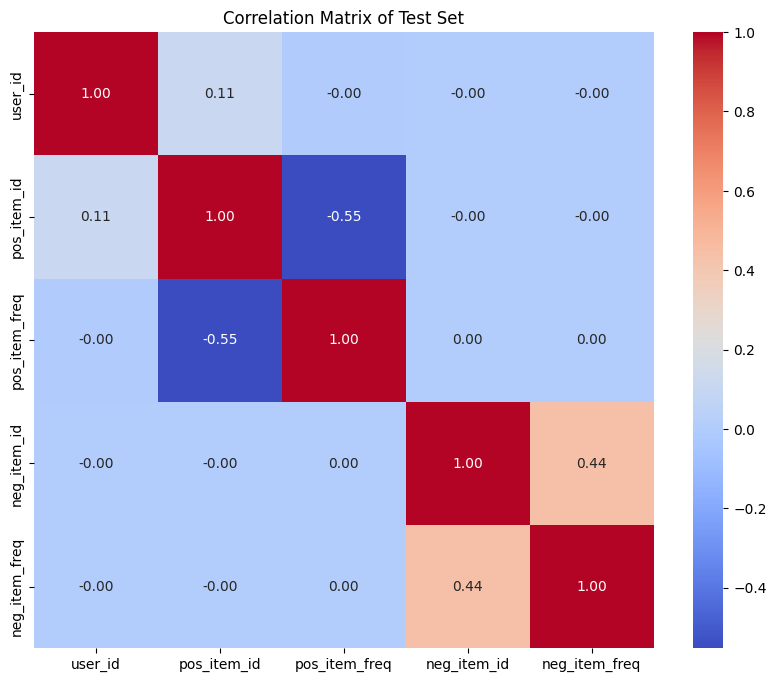

In [11]:
corr = df_new_train.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Test Set')
plt.show()

#### 1:1 Uniform Train Set 

In [12]:
columns_train = ['user_id', 'pos_item_id','neg_item_id']
df_train_1_1 = pd.DataFrame(train_1_1, columns=columns_train)

In [13]:
df_train_1_1.shape

(41813, 3)

In [14]:
df_train_1_1

,user_id,pos_item_id,neg_item_id
0,1388,2970,299
1,1194,3887,1933
2,353,1264,558
3,1460,2439,2120
4,405,379,2211
...,...,...,...
41808,1601,670,429
41809,260,505,1122
41810,1568,2840,1142
41811,1275,1586,2390


In [15]:
train_pos_item_freq_dict = df_train_1_1.pos_item_id.value_counts().to_dict()
train_neg_item_freq_dict = df_train_1_1.neg_item_id.value_counts().to_dict()

In [16]:
rows_train = []

# Iterate over the existing DataFrame
for _, row in df_train_1_1.iterrows():
    user_id = row['user_id']
    pos_item_id = row['pos_item_id']
    pos_item_freq = train_pos_item_freq_dict.get(pos_item_id, 0)
    neg_item_id = row['neg_item_id']
    neg_item_freq = train_neg_item_freq_dict.get(neg_item_id, 0)
    rows_train.append([user_id, pos_item_id, pos_item_freq, neg_item_id, neg_item_freq])

# Convert the list of rows into a new DataFrame
columns = ['user_id', 'pos_item_id', 'pos_item_freq', 'neg_item_id', 'neg_item_freq']
df_new_train_1_1 = pd.DataFrame(rows_train, columns=columns)


In [17]:
df_new_train_1_1

,user_id,pos_item_id,pos_item_freq,neg_item_id,neg_item_freq
0,1388,2970,7,299,11
1,1194,3887,2,1933,11
2,353,1264,12,558,12
3,1460,2439,4,2120,10
4,405,379,18,2211,12
...,...,...,...,...,...
41808,1601,670,9,429,11
41809,260,505,8,1122,7
41810,1568,2840,8,1142,14
41811,1275,1586,17,2390,16


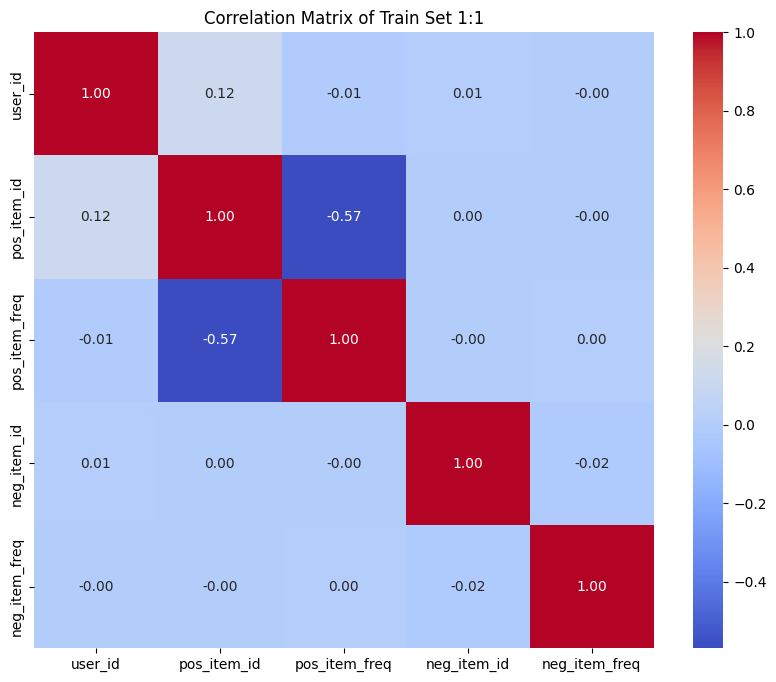

In [18]:
corr = df_new_train_1_1.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Train Set 1:1')
plt.show()

In [19]:
result = pd.merge(df_new_train_1_1, df_gt, on='user_id', how='inner')

In [20]:
result

,user_id,pos_item_id,pos_item_freq,neg_item_id,neg_item_freq,GT_item_id
0,1388,2970,7,299,11,324
1,1388,2970,7,299,11,837
2,1388,2970,7,299,11,518
3,1388,2970,7,299,11,885
4,1388,2970,7,299,11,1004
...,...,...,...,...,...,...
1164352,502,3647,4,3742,16,956
1164353,502,3647,4,3742,16,1394
1164354,502,3647,4,3742,16,1962
1164355,502,3647,4,3742,16,1393


In [21]:
# GerceKte 1 olan ancak neg sampling esnasinda sifir isaretlenen item'lar = False Negative
filtered_df = result[result['neg_item_id'] == result['GT_item_id']]

In [22]:
filtered_df

,user_id,pos_item_id,pos_item_freq,neg_item_id,neg_item_freq,GT_item_id
3182,826,1842,16,3533,11,3533
16494,344,370,49,3202,8,3202
21987,1739,1501,4,704,13,704
22659,1874,1111,23,962,12,962
26105,270,1660,4,421,11,421
...,...,...,...,...,...,...
1148655,412,3431,3,2422,13,2422
1151179,1565,1775,21,503,9,503
1152819,616,1131,14,1626,8,1626
1153930,896,624,70,2469,14,2469


In [23]:
filtered_df[filtered_df['pos_item_freq'] <= 50].pos_item_freq.describe()

count    200.000000
mean      18.650000
std       13.607842
min        2.000000
25%        7.000000
50%       14.000000
75%       29.000000
max       49.000000
Name: pos_item_freq, dtype: float64

In [24]:
filtered_df[filtered_df['pos_item_freq'] <= 50].neg_item_freq.describe()

count    200.000000
mean      10.715000
std        3.293633
min        2.000000
25%        8.000000
50%       10.500000
75%       13.000000
max       21.000000
Name: neg_item_freq, dtype: float64

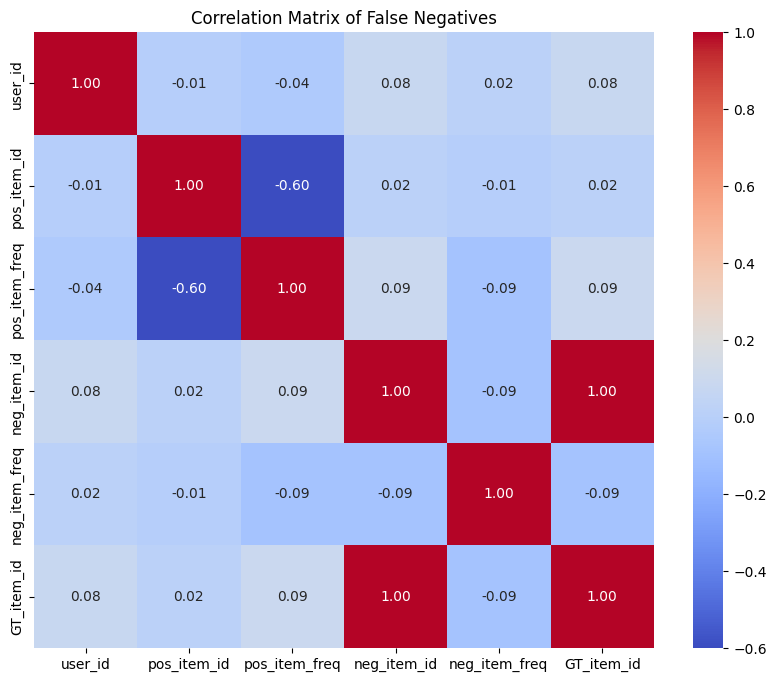

In [25]:
corr = filtered_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of False Negatives')
plt.show()

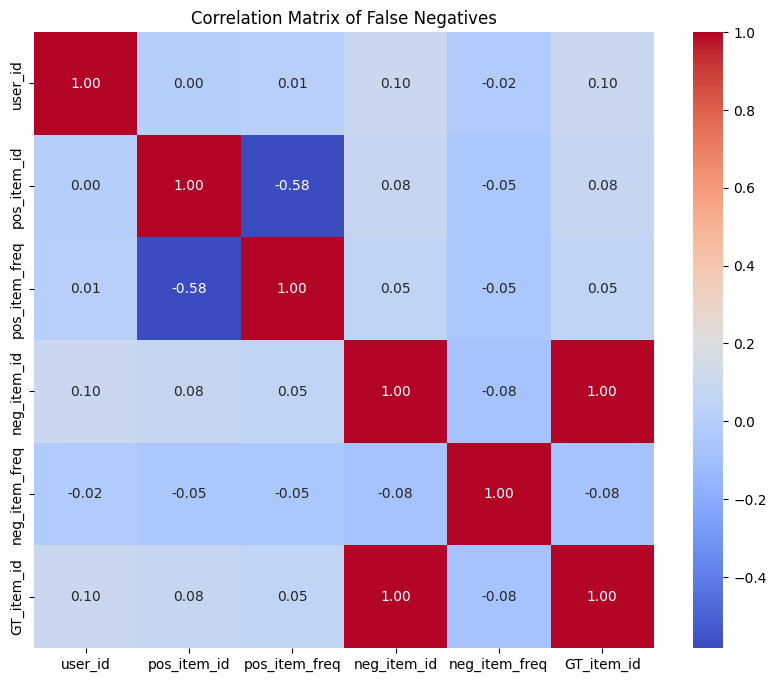

In [33]:
corr = filtered_df[filtered_df['pos_item_freq'] <= 50].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of False Negatives')
plt.show()

#### 1:100 Uniform Train Set 

In [27]:
columns_train = ['user_id', 'pos_item_id','neg_item_id']
df_train_1_100 = pd.DataFrame(train_1_100, columns=columns_train)

In [28]:
df_train_1_100.shape

(4183200, 3)

In [29]:
train_1_100__pos_item_freq_dict = df_train_1_100.pos_item_id.value_counts().to_dict()
train_1_100_neg_item_freq_dict = df_train_1_100.neg_item_id.value_counts().to_dict()

In [30]:
rows_train = []

# Iterate over the existing DataFrame
for _, row in tqdm(df_train_1_100.iterrows(), total=len(df_train_1_100)):
    user_id = row['user_id']
    pos_item_id = row['pos_item_id']
    pos_item_freq = train_1_100__pos_item_freq_dict.get(pos_item_id, 0)
    neg_item_id = row['neg_item_id']
    neg_item_freq = train_1_100_neg_item_freq_dict.get(neg_item_id, 0)
    rows_train.append([user_id, pos_item_id, pos_item_freq, neg_item_id, neg_item_freq])

# Convert the list of rows into a new DataFrame
columns = ['user_id', 'pos_item_id', 'pos_item_freq', 'neg_item_id', 'neg_item_freq']
df_new_train_1_100 = pd.DataFrame(rows_train, columns=columns)

  0%|          | 4003/4183200 [00:00<05:16, 13206.28it/s]

100%|██████████| 4183200/4183200 [03:38<00:00, 19154.99it/s]


In [31]:
df_new_train_1_100

,user_id,pos_item_id,pos_item_freq,neg_item_id,neg_item_freq
0,759,1067,6400,189,928
1,759,1067,6400,3688,940
2,759,1067,6400,1140,946
3,759,1067,6400,1071,916
4,759,1067,6400,1128,887
...,...,...,...,...,...
4183195,1715,635,2900,3472,919
4183196,1715,635,2900,4307,920
4183197,1715,635,2900,1092,899
4183198,1715,635,2900,3994,952


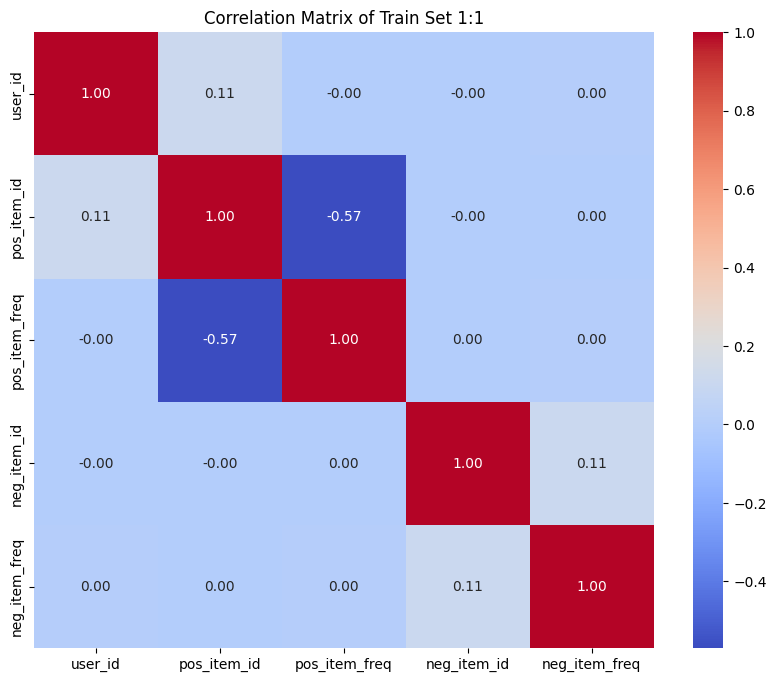

In [32]:
corr = df_new_train_1_100.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Train Set 1:1')
plt.show()

In [38]:
result_1_100 = pd.merge(df_new_train_1_100, df_gt, on='user_id', how='inner')

: 

In [ ]:
result_1_100

In [ ]:
# GerceKte 1 olan ancak neg sampling esnasinda sifir isaretlenen item'lar = False Negative
filtered_df_100 = result_1_100[result_1_100['neg_item_id'] == result_1_100['GT_item_id']]

In [ ]:
filtered_df_100

In [ ]:
filtered_df_100[filtered_df_100['pos_item_freq'] <= 50].pos_item_freq.describe()

In [ ]:
corr = filtered_df_100.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of False Negatives')
plt.show()

In [ ]:
corr = filtered_df_100[filtered_df_100['pos_item_freq'] <= 10].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of False Negatives')
plt.show()

#### Proposes

Heat Kernel: 

The heat kernel is a diffusion-based measure that quantifies the influence of a node on other nodes in the graph. It is based on the heat equation, which describes how heat diffuses over time in a physical system. The heat kernel can be personalized to capture the influence of a specific node or set of nodes on others.

Heat Kernel Matrix:
[[-0.00000000e+00  2.50000000e-01  2.50000000e-01  5.00000000e-01]
 [ 0.00000000e+00  2.25179981e+15  2.25179981e+15 -4.50359963e+15]
 [ 0.00000000e+00  2.25179981e+15  2.25179981e+15 -4.50359963e+15]
 [ 1.00000000e+00 -4.50359963e+15 -4.50359963e+15  9.00719925e+15]]


<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


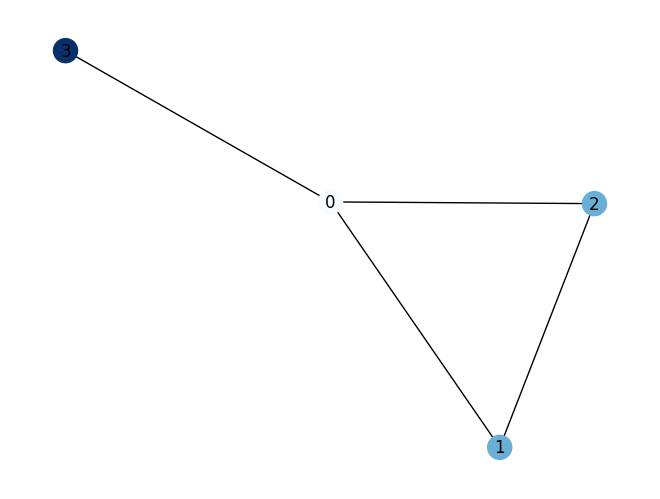

In [53]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create a graph (e.g., a simple 4-node graph)
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2)])

# Construct the Laplacian matrix
L = nx.laplacian_matrix(G).toarray()

# Define the time parameter for heat diffusion
t = 1.0

# Calculate the heat kernel matrix using matrix exponential
H_t = np.linalg.matrix_power(np.eye(G.number_of_nodes()) - t * L, -1)

# Display the heat kernel matrix
print("Heat Kernel Matrix:")
print(H_t)

# Plot the graph with node colors based on the heat kernel values
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=H_t[0], cmap=plt.cm.Blues)
plt.show()


The heat kernel matrix provides information about the diffusion of heat (or information, influence, etc.) over the graph at a specific time \( t \). Each element \( H_t(i, j) \) of the heat kernel matrix represents the amount of "heat" at node \( j \) at time \( t \) that originated from node \( i \) in the initial distribution.

Interpreting the heat kernel matrix can provide insights into the graph structure and connectivity. Nodes that are closely connected or part of the same cluster are likely to have similar heat values, indicating that heat diffuses quickly between them. Conversely, nodes that are not well connected may have lower heat values, indicating slower diffusion between them.

In visualization, the heat kernel matrix can be used to color nodes in a graph, where nodes with higher heat values are displayed with warmer colors (e.g., red) and nodes with lower heat values are displayed with cooler colors (e.g., blue). This visualization can help identify clusters or communities within the graph and understand the flow of information or influence over the graph.

/tmp/ipykernel_9109/211431079.py:13: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  L_sparse = nx.bipartite.biadjacency_matrix(G, row_order=[1, 2, 3], column_order=['a', 'b', 'c'])


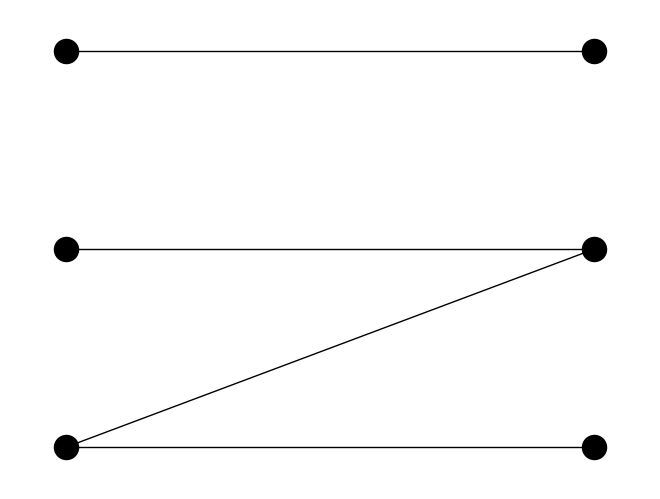

In [66]:
import networkx as nx
import numpy as np
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

# Create a bipartite graph (e.g., a simple user-item graph)
G = nx.Graph()
G.add_nodes_from([1, 2, 3], bipartite=0)  # User nodes
G.add_nodes_from(['a', 'b', 'c'], bipartite=1)  # Item nodes
G.add_edges_from([(1, 'a'), (1, 'b'), (2, 'b'), (3, 'c')])

# Construct the bipartite Laplacian matrix
L_sparse = nx.bipartite.biadjacency_matrix(G, row_order=[1, 2, 3], column_order=['a', 'b', 'c'])
L = csc_matrix(L_sparse)  # Convert to CSC format for better performance

# Define the time parameter for heat diffusion
t = 1.0

# Calculate the heat kernel matrix using pseudo-inverse
H_t = np.linalg.pinv(np.eye(L.shape[0]) - t * L.A)

# Plot the graph with node colors based on the heat kernel values
pos = nx.bipartite_layout(G, [1, 2, 3])
node_colors = H_t[0]  # Use the first row of the heat kernel matrix for node colors
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Blues)
plt.show()


In [57]:
# Display the heat kernel matrix
print("Heat Kernel Matrix:")
print(H_t)

[[ 0.  0.  0.]
 [-1.  0.  0.]
 [ 0.  0.  0.]]


FP growth kullanilabilir mi ?


sadece non-interacted data uzerinde FP growth gibi bir algo calistirilip, neg sampling yapilabilir mi ?